In [1]:
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt

In [2]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Load the image and rescale it in $[0,1]$

In [4]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [5]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [6]:
mse = np.mean((img-noisy_img)**2)
psnr_noisy = 10*np.log10(1/mse)
psnr_noisy

np.float64(22.127989344344336)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.13')

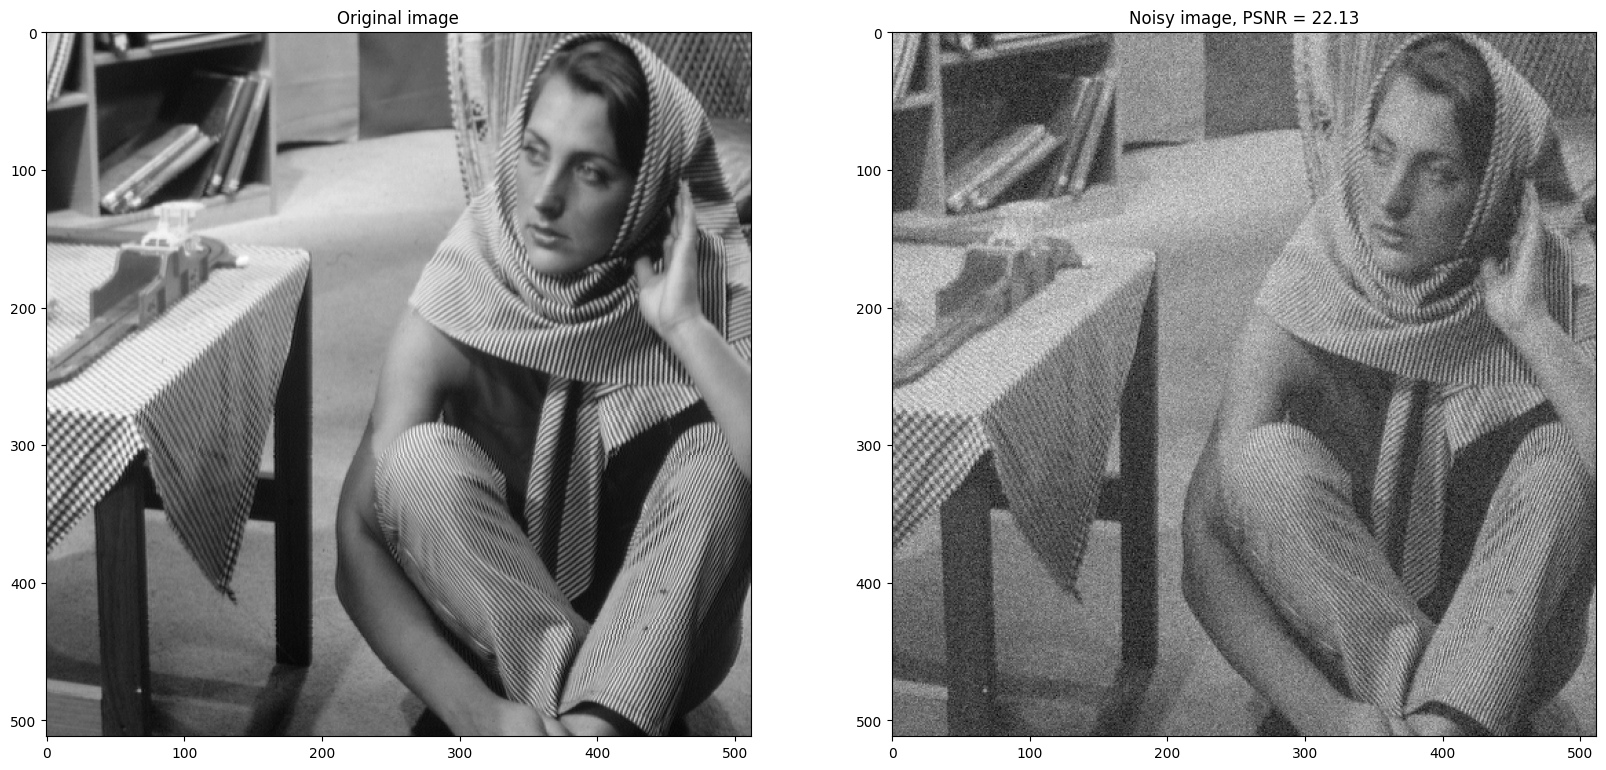

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Generate the Global PCA basis for this image
--------------------------------------------

Set the parameters for denoising

In [8]:
# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))

Stack all the image patches in a large matrix $S$. Each patch goes in a column of $S$

In [9]:
n = 64
m = (imsz[0]+1 - p)*(imsz[1]+1 - p)
S = np.zeros((n,m))
cont = 0
for i in range(0, imsz[0] - p + 1):
    for j in range(0, imsz[1] - p + 1):
        x_patch = noisy_img[i:i+p, j:j+p].reshape(-1)
        S[:,cont] = x_patch
        cont += 1

S.shape

(64, 255025)

Compute $\tilde S$ by zero centering $S$


In [10]:
avg_patch = np.mean(S, axis=0)
print(avg_patch)
Stilde = S - avg_patch
Stilde

[0.76841055 0.77922609 0.76924189 ... 0.42332727 0.42390753 0.42739451]


array([[ 0.09819336, -0.18129015,  0.16045194, ..., -0.00685657,
         0.04707584, -0.05569694],
       [-0.1704746 ,  0.15046773, -0.09978793, ...,  0.0476561 ,
        -0.05220996,  0.06691128],
       [ 0.16128328, -0.10977214, -0.07720761, ..., -0.0516297 ,
         0.07039826,  0.11069771],
       ...,
       [ 0.09295375,  0.01699408,  0.21509345, ..., -0.1537281 ,
        -0.10064684, -0.02368237],
       [ 0.02780962,  0.20510924, -0.12965752, ..., -0.10006658,
        -0.02019539, -0.06698235],
       [ 0.21592479, -0.13964173, -0.21195375, ..., -0.01961514,
        -0.06349538, -0.11371026]])

Compute the PCA transformation via SVD


In [11]:
optimized_S = Stilde @ Stilde.T
U, Sigma, V = np.linalg.svd(optimized_S)

Show the learned PCA basis

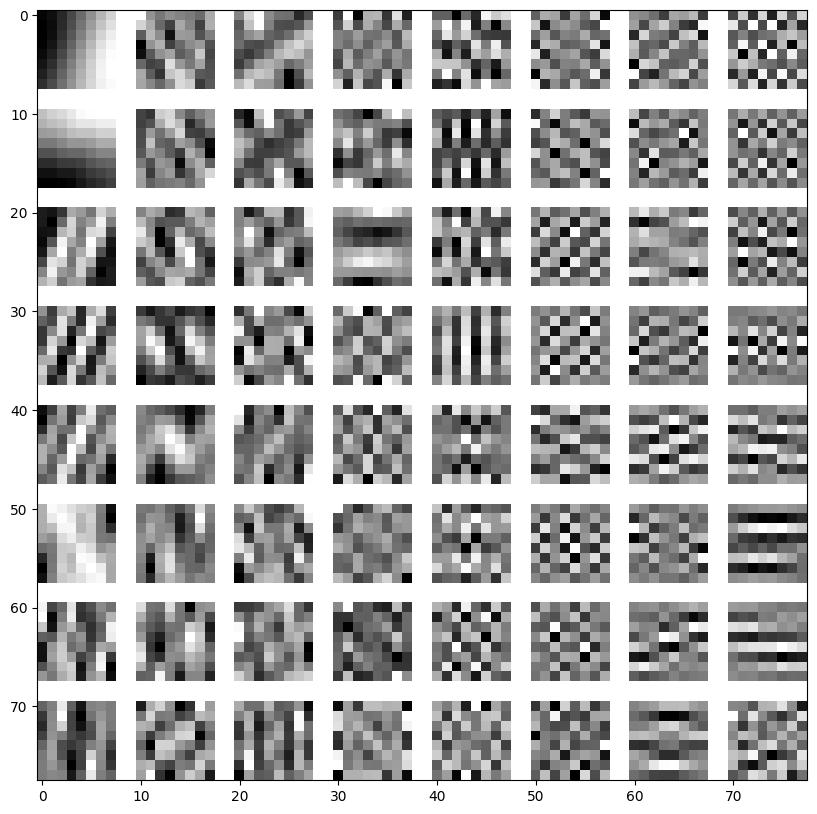

In [12]:
U_img = get_dictionary_img(U)
plt.figure(figsize=(10,10))
plt.imshow(U_img, cmap='gray')

Patch-based denoising
---------------------
Initialize the variables

In [13]:
STEP = 1

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [14]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p]

        # Preprocessing: remember to subtract the avg_patch (preprocessing used for PCA)
        avg_s = np.mean(s)
        # print(avg_patch)
        # print(s)      
        s = s - avg_s
        # print(s)
        
        # compute the representation w.r.t. the PCA basis
        x = U.T @ s.reshape(-1)
        # perform the hard thresholding
        x_hat = np.where(np.abs(x) > tau, x, 0)
        # x_hat[0,0] = x[0,0] # to ask: leave original value of DC
        
        # synthesis: perform the reconstruction
        y_hat = U @ x_hat

        # add the avg patch back
        y_hat += avg_s

        # compute the weight for the reconstructed patch
        w = 1

        # put the compressed patch into the compressed image using the computed weight
        # UPDATE img_hat
        img_hat[i:i+p, j:j+p] += (y_hat*w).reshape((p,p))

        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        weights[i:i+p, j:j+p] += w
        

# normalize the estimated image with the computed weights
img_hat = img_hat / weights


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 29.58')

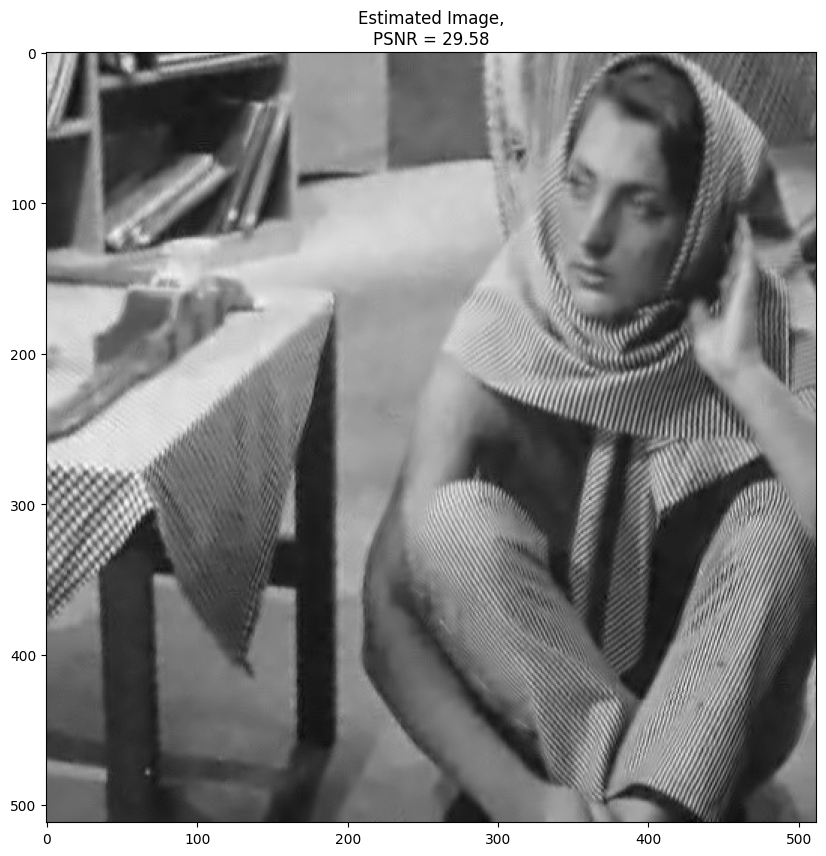

In [15]:
mse = np.mean((img-img_hat)**2)
psnr_hat = 10*np.log10(1/mse)

plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')